<a href="https://colab.research.google.com/github/Fanusaez/7506R-2C2022-GRUPO13/blob/sabado-1-10-2022/7506R_TP1_GRUPO13_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Trabajo Practico 1 : Propiedades en Venta

## Grupo 13

### Integrantes:

- Ivan Manuel Pensado
- Axel Tomas Higa
- Edgardo Francisco Saez
- Lautaro Barrionuevo
- Nicolás Carreño


# Importe de librerias


In [161]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import scipy.stats as st

from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, MinMaxScaler

import geopandas
from shapely.geometry import Point
import osmnx as ox

# Lectura de archivo


In [162]:
ds_propiedades = pd.read_csv('properati_argentina_2021.csv')

In [163]:
ds_propiedades.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


# Análisis Exploratorio y Preprocesamiento de Dato


Se deben filtrar únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).

In [164]:
ds_prop_filtrado = ds_propiedades[ds_propiedades.place_l2.str.contains('Capital Federal', case=False, na = False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.property_type.str.fullmatch('Departamento|Casa|ph', case = False, na = False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.operation.str.contains('venta', case=False, na =  False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.property_currency.str.contains('USD', case=False, na =  False)] 

Division Train/Test

In [165]:
train, test = train_test_split(ds_prop_filtrado,
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=0)
print('# Datos Entrenamiento: {}'.format(len(train)))
print('# Datos Prueba: {}'.format(len(test)))

# Datos Entrenamiento: 75399
# Datos Prueba: 18850


## Exploración inicial


Tipo de variable


In [167]:
 #ds_prop_filtrado = train   preguntar

In [168]:
ds_prop_filtrado.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l2                     object
place_l3                     object
place_l4                     object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

Variables Cuantitativas


In [169]:
cuantitativos = ["latitud", "longitud", "property_rooms", "property_bedrooms","property_surface_total", "property_surface_covered", "property_price"]
ds_cuantitativo = ds_prop_filtrado.loc[:,cuantitativos]
ds_resumen_cuantitativo = pd.DataFrame()
ds_resumen_cuantitativo["media"] = ds_cuantitativo.mean()
ds_resumen_cuantitativo["mediana"] = ds_cuantitativo.median()
ds_resumen_cuantitativo["q1"] = ds_cuantitativo.quantile([.25]).iloc[0]
ds_resumen_cuantitativo["q3"] = ds_cuantitativo.quantile([.75]).iloc[0]
ds_resumen_cuantitativo["moda"] = ds_cuantitativo.mode().iloc[0]
ds_resumen_cuantitativo

,media,mediana,q1,q3,moda
latitud,-34.591481,-34.59579,-34.615975,-34.577413,-34.541250
longitud,-58.449795,-58.43900,-58.466522,-58.408862,-58.472966
property_rooms,2.822799,3.00000,2.000000,4.000000,3.000000
property_bedrooms,2.014629,2.00000,1.000000,3.000000,1.000000
property_surface_total,109.092970,65.00000,45.000000,105.000000,50.000000
property_surface_covered,87.931932,58.00000,40.000000,88.000000,40.000000
property_price,226238.207185,143900.00000,95000.000000,237000.000000,110000.000000


Variables Cualitativas


In [170]:
cualitativos = ["place_l2", "place_l3", "operation", "property_type", "property_currency", "property_title"]
ds_cualitativo = ds_prop_filtrado.loc[:,cualitativos]

- Mostrar cantidad de valores posibles


In [171]:
ds_cualitativo.nunique()

place_l2                 1
place_l3                57
operation                1
property_type            3
property_currency        1
property_title       55704
dtype: int64

- Mostrar frecuencias
  - Obviamos las opciones de un solo tipo porque la frecuencia es de 100%


In [172]:
ds_cualitativo.place_l3.value_counts(normalize=True)* 100

Palermo                 15.248529
Belgrano                 9.482906
Caballito                7.639185
Recoleta                 6.694944
Villa Urquiza            4.980177
Almagro                  4.349263
Nuñez                    3.779095
Villa Crespo             3.398627
Flores                   3.314434
Barrio Norte             3.170560
Balvanera                2.720820
Colegiales               2.079248
Villa Devoto             2.047276
Villa del Parque         1.949228
Saavedra                 1.949228
Puerto Madero            1.591142
San Telmo                1.470714
San Cristobal            1.385455
San Nicolás              1.380126
Retiro                   1.332168
Barracas                 1.327905
Boedo                    1.318314
Floresta                 1.273553
Monserrat                1.188294
Parque Chacabuco         1.143533
Villa Pueyrredón         1.077458
Coghlan                  1.048683
Villa Luro               0.774789
Mataderos                0.766263
Chacarita     

In [173]:
ds_cualitativo.property_type.value_counts(normalize=True)* 100

Departamento    85.761122
PH               9.831404
Casa             4.407474
Name: property_type, dtype: float64

In [174]:
ds_cualitativo.property_title.value_counts(normalize=True)* 100

Departamento - Palermo                                                                                  1.557576
Departamento - Recoleta                                                                                 1.404789
Departamento - Belgrano                                                                                 1.180914
Departamento - Caballito                                                                                0.993114
Departamento - Almagro                                                                                  0.706639
                                                                                                          ...   
Gran 3 ambientes en pleno Villa del Parque                                                              0.001061
Venta PH 3 Amb Con Patio Flores                                                                         0.001061
Venta, PH, 3 Ambientes, PB, Quincho, Parrilla, Terraza, Paternal                                

- Determinar variables irrelevantes en el análisis


Debido a que las caracteristicas cualitativas "place_l2", "operation", "Property_currency" solo poseen un valor posible, es irrelevante para el analisis de datos. Tambien la caracteristica de "Property_title" al ser una descripcion del vendedor no aporta mucha informacion analitica. Por ultimo, los datos que no aportan al analisis, son las fechas, de las columnas "Start_date", "End_date" y "Created_on" debido a que no se especifica que significa dichas fechas.


In [175]:
columnas_a_eliminar = ["id","place_l5","place_l6"] # variables irrelevantes, podrian ser: property_title place_l5	place_l6 y (start_date created_on) son lo mismo
ds_filtado_copia = ds_prop_filtrado.copy()
ds_filtado_copia.drop(columns = columnas_a_eliminar, inplace = True)

Duplicados


In [176]:
ds_filtado_copia.duplicated

<bound method DataFrame.duplicated of         start_date    end_date  created_on    latitud   longitud  \
25      2021-09-09  2021-09-26  2021-09-09        NaN        NaN   
42      2021-09-09  2021-09-26  2021-09-09 -34.637319 -58.361124   
43      2021-09-09  2021-09-28  2021-09-09 -34.628647 -58.361871   
49      2021-09-09  2022-01-05  2021-09-09 -34.610027 -58.401934   
51      2021-09-09  2022-03-09  2021-09-09 -34.631621 -58.416825   
...            ...         ...         ...        ...        ...   
460072  2021-01-05  2022-09-02  2021-01-05 -34.603245 -58.489810   
460073  2021-01-05  2021-02-17  2021-01-05 -34.614063 -58.482814   
460074  2021-01-05  2021-01-27  2021-01-05 -34.614175 -58.479062   
460075  2021-01-05  2021-01-27  2021-01-05 -34.614175 -58.479062   
460090  2021-01-05  2021-01-08  2021-01-05 -34.599790 -58.373411   

               place_l2              place_l3 place_l4 operation  \
25      Capital Federal                   NaN      NaN     Venta   
42      C

- Realizar un análisis gráfico de las distribuciones de las variables


In [177]:

#sns.pairplot(ds_filtado_copia)

###Correlaciones existentes entre las variables


- Analizar las correlaciones existentes entre las variables.


In [178]:
ds_prop_filtrado.corr()

,latitud,longitud,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
latitud,1.000000,-0.239235,NaN,0.005521,0.003162,0.025348,0.002352,0.016635
longitud,-0.239235,1.000000,NaN,-0.008324,-0.008556,-0.015056,-0.001155,0.023314
place_l6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
property_rooms,0.005521,-0.008324,NaN,1.000000,0.871940,0.067211,0.076097,0.488934
property_bedrooms,0.003162,-0.008556,NaN,0.871940,1.000000,0.067702,0.075075,0.425386
property_surface_total,0.025348,-0.015056,NaN,0.067211,0.067702,1.000000,0.604311,0.085235
property_surface_covered,0.002352,-0.001155,NaN,0.076097,0.075075,0.604311,1.000000,0.056238
property_price,0.016635,0.023314,NaN,0.488934,0.425386,0.085235,0.056238,1.000000


Precio promedio de propiedad por Barrio


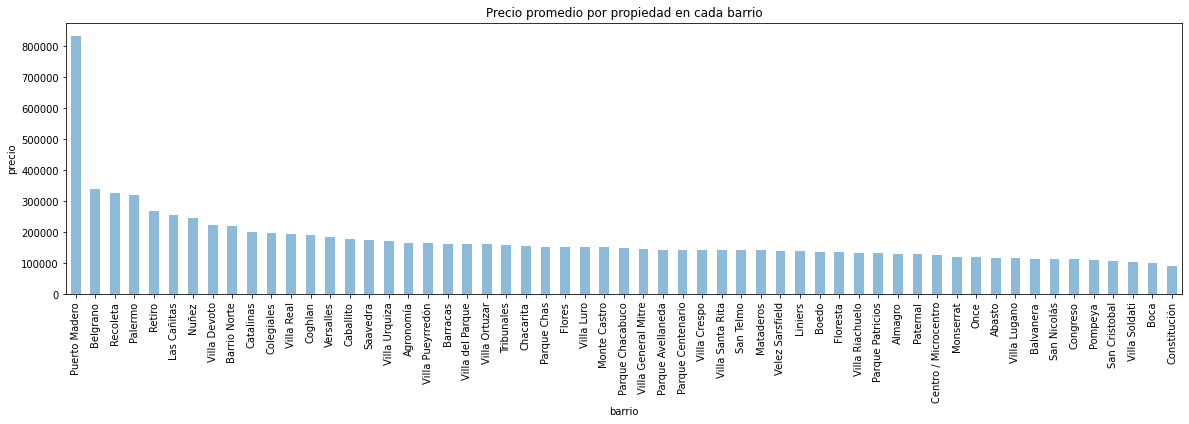

In [179]:
ds_precio_prom = ds_prop_filtrado.groupby(["place_l3"])["property_price"].mean().sort_values(ascending=False)
grf_ds=ds_precio_prom.plot.bar(alpha=0.5 , title="Precio promedio por propiedad en cada barrio" , xlabel="barrio" , ylabel="precio", figsize=(20,5))

### Conslusiones exploracion inicial

El analisis al que podemos llegar con la exoloracion inicial realizada es:

- Tenemos mucha mayor cantidad de propiedades de tipo "Departamento", que de tipo "Casa" o "PH"
- Mucha cantidad de propiedades en zonas como Palermo, Belgrano, Caballito y Recoleta
- La zona con el promedio de precios mas alto es Puerto Madero 
- Encontramos columnas en el dataset que debido a su falta de utilidad en el trabajo o su alto porcentaje de valores faaltantes, decidimos sacarlos del dataset

## Datos faltantes


Realizar análisis de datos faltantes a nivel de columna. Graficar para cada variable
el porcentaje de datos faltantes con respecto al total del dataset


In [180]:
filas_totales=ds_prop_filtrado.shape[0]
print(ds_prop_filtrado.isna().sum()/filas_totales*100)

id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.957602
longitud                      3.957602
place_l2                      0.000000
place_l3                      0.442445
place_l4                     96.134707
place_l5                    100.000000
place_l6                    100.000000
operation                     0.000000
property_type                 0.000000
property_rooms                1.107704
property_bedrooms            11.657418
property_surface_total        5.139577
property_surface_covered      3.558658
property_price                0.000000
property_currency             0.000000
property_title                0.000000
dtype: float64


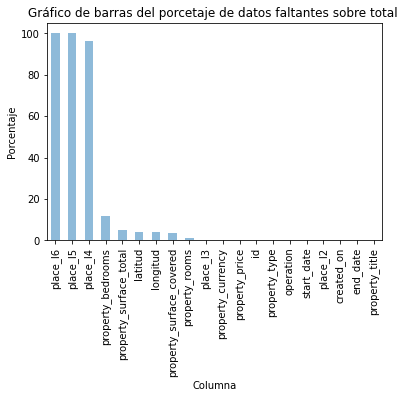

In [181]:
ds_porcentaje = ds_prop_filtrado.isna().sum()/filas_totales*100
ds_porcentaje = ds_porcentaje.sort_values(ascending=False)
grf_ds = ds_porcentaje.plot.bar(alpha=0.5 , title="Gráfico de barras del porcetaje de datos faltantes sobre total " , xlabel="Columna" , ylabel="Porcentaje")

Nos fijamos si hay algun valor sospechoso que sea negativo


In [182]:
columnas_con_numeros = ['property_price', 'property_surface_total', 'property_surface_covered', 'property_rooms', 'property_bedrooms']
(ds_prop_filtrado[columnas_con_numeros] <= 0).any().to_frame('Menor que 0 ?')

,Menor que 0 ?
property_price,False
property_surface_total,False
property_surface_covered,False
property_rooms,False
property_bedrooms,True


Property_bedrooms tiene numero negativo, asi que veo cuantos hay


In [183]:
ds_prop_filtrado[ds_prop_filtrado['property_bedrooms'] < 1]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
406880,3WI+zCCMeb9TR5kOBm7rhg==,2021-01-07,2021-03-18,2021-01-07,-34.577595,-58.495185,Capital Federal,Villa Urquiza,NaN,NaN,NaN,Venta,Departamento,2.0,-1.0,61.0,43.0,125000.0,USD,Jardines de Roosevelt - Hermoso 3 ambientes co...


Solo hay uno asi que se lo coloca en nan porque no condiciona el analisis pero si el dato es incorrecto


In [184]:
ds_prop_filtrado.loc[ds_prop_filtrado['property_bedrooms'] < 1,'property_bedrooms'] = np.nan
ds_prop_filtrado[ds_prop_filtrado['id'] == '3WI+zCCMeb9TR5kOBm7rhg==']

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
406880,3WI+zCCMeb9TR5kOBm7rhg==,2021-01-07,2021-03-18,2021-01-07,-34.577595,-58.495185,Capital Federal,Villa Urquiza,NaN,NaN,NaN,Venta,Departamento,2.0,NaN,61.0,43.0,125000.0,USD,Jardines de Roosevelt - Hermoso 3 ambientes co...


Tomando en cuenta estos resultados, decidimos eliminar las columnas l4 , l5 y l6 debido a que el porcentaje de datos faltantes es total o casi total. En el caso de l5 y l6 son de 100 por ciento por lo cual no se podria completar y en el caso de l4 son las subdivisiones barriales de los cuales muchos no poseen.


In [185]:
columnas_a_eliminar = ["place_l4","place_l5","place_l6"]
ds_prop_filtrado.drop(columns = columnas_a_eliminar, inplace = True)

Realizar un análisis de datos faltantes a nivel de fila. Calcular el porcentaje de
datos faltantes de cada registro. Realizar un gráfico que permita conocer la
proporción de faltantes por fila en el dataset.


In [186]:
filas_cantidad_nan = pd.DataFrame(ds_prop_filtrado).isna().sum(axis=1).to_frame("cantidad")
cantidad = len(filas_cantidad_nan[filas_cantidad_nan["cantidad"] > 0])
print(f"Hay {cantidad} lineas que poseen uno o mas valores faltantes")

Hay 21387 lineas que poseen uno o mas valores faltantes


Verificamos que no haya duplicados y las eliminamos


In [187]:
print(ds_prop_filtrado[ds_prop_filtrado.duplicated(keep=False)])
ds_prop_filtrado = ds_prop_filtrado.drop_duplicates()

        start_date    end_date  created_on    latitud   longitud  \
1093    2021-09-09  2022-01-27  2021-09-09 -34.604660 -58.395385   
1094    2021-09-09  2022-01-27  2021-09-09 -34.604660 -58.395385   
1095    2021-09-09  2022-01-27  2021-09-09 -34.604660 -58.395385   
1096    2021-09-09  2022-01-27  2021-09-09 -34.604660 -58.395385   
1239    2021-09-09  2022-02-09  2021-09-09 -34.580818 -58.491051   
...            ...         ...         ...        ...        ...   
459606  2021-01-05  2021-01-10  2021-01-05 -34.555751 -58.463942   
459953  2021-01-05  2021-03-06  2021-01-05 -34.605691 -58.443852   
459959  2021-01-05  2021-03-06  2021-01-05 -34.605691 -58.443852   
459961  2021-01-05  2021-04-08  2021-01-05 -34.599486 -58.432429   
459962  2021-01-05  2021-04-08  2021-01-05 -34.599486 -58.432429   

               place_l2       place_l3 operation property_type  \
1093    Capital Federal   Barrio Norte     Venta  Departamento   
1094    Capital Federal   Barrio Norte     Venta  D

_Determinar, de ser posible, estrategias para reparar los valores faltantes._


Dado que poseemos la latitud y longitud de casi todas las propiedades, vamos a utilizar imputacion Cold Deck, para rellenar los datos faltantes de la columna "place_l3"

Primero procedemos imputando los cualitativos, que en este caso solo es el place_l3.
Utilizando un archivo csv proporcionado por el gobierno de la Ciudad Autonoma de Buenos Aires, el cual nos proporcionorá el nombre de la localidad usando latitud y longitud, mediante la utilizacion de Polygon.
https://data.buenosaires.gob.ar/dataset/barrios


In [188]:
ds_barrios = pd.read_csv('barrios.csv', header=0,sep=';')

from shapely.geometry import MultiPolygon, Polygon, Point
from shapely import wkt
ds_barrios.WKT = ds_barrios.WKT

for index, registro_prop in ds_prop_filtrado.iterrows():
    if  type(registro_prop["place_l3"]) is str:
        continue
    for index_, registro_barrio in ds_barrios.iterrows():
        if wkt.loads(registro_barrio.WKT).covers(Point(registro_prop.longitud,registro_prop.latitud)):
            barrio_aux = registro_barrio['BARRIO']
            ds_prop_filtrado.loc[index, 'place_l3'] = barrio_aux

Me fijo si quedo algun place_l3 incompleto.


In [189]:
ds_prop_filtrado[ds_prop_filtrado["place_l3"].isna()]

,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
25,2021-09-09,2021-09-26,2021-09-09,NaN,NaN,Capital Federal,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,USD,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA
3088,2021-02-20,2022-02-09,2021-02-20,-31.6789,-63.87964,Capital Federal,NaN,Venta,Casa,5.0,4.0,220.0,220.0,230000.0,USD,VENTA HERMOSA CASA 5 AMB. C/PILETA - BOCA RATÓN
3099,2021-02-20,2021-03-01,2021-02-20,NaN,NaN,Capital Federal,NaN,Venta,Casa,3.0,2.0,69.0,53.0,54600.0,USD,Venta Duplex 3 amb. Complejo Quimaral I - San ...
5942,2021-10-29,2022-01-08,2021-10-29,NaN,NaN,Capital Federal,NaN,Venta,Departamento,3.0,2.0,87.0,87.0,117000.0,USD,impecable 3 Ambientes de 88 m2!!!! con 2 baños...
6699,2021-02-09,2021-06-05,2021-02-09,NaN,NaN,Capital Federal,NaN,Venta,Casa,NaN,3.0,NaN,390.0,795000.0,USD,Magnífica casa a la venta de 7 ambientes en Ab...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458690,2021-01-05,2021-03-01,2021-01-05,NaN,NaN,Capital Federal,NaN,Venta,Casa,NaN,2.0,NaN,80.0,120000.0,USD,Casa a reciclar 3 Amb. en San Martin
458696,2021-01-05,2021-03-01,2021-01-05,NaN,NaN,Capital Federal,NaN,Venta,Casa,NaN,2.0,60.0,60.0,75000.0,USD,CASA 3 AMBIENTES CON TERRAZA
459187,2021-01-05,2021-03-01,2021-01-05,NaN,NaN,Capital Federal,NaN,Venta,Departamento,2.0,1.0,41.0,41.0,75000.0,USD,San Martín. Centro depto 2 amb a estrenar.
459195,2021-01-05,2021-03-01,2021-01-05,NaN,NaN,Capital Federal,NaN,Venta,Departamento,2.0,1.0,44.0,44.0,128000.0,USD,San Martin Ctro. s/ San Lorenzo Impecable Dpto...


Eliminamos aquellas que no tengan place_l3 porque no se pueden completar por el barrio o tienen mal el dato ej dato con latitud -31.678 y longitud -63.87964 pertenece a Cordoba pero place_l2 es Capital federal por lo que puede ser que el dato este subido erroneamente y tambien eliminamos los registus sin latitud ni longitud porque no es posible saber su dato exacto y puede ser un registro mal cargado. Y vemos cuantos datos faltantes quedan.


In [190]:
ds_prop_filtrado = ds_prop_filtrado[~ds_prop_filtrado["place_l3"].isna() & ~ds_prop_filtrado["latitud"].isna() & ~ds_prop_filtrado["longitud"].isna()]
filas_totales=ds_prop_filtrado.shape[0]
print(ds_prop_filtrado.isna().sum()/filas_totales*100)

start_date                   0.000000
end_date                     0.000000
created_on                   0.000000
latitud                      0.000000
longitud                     0.000000
place_l2                     0.000000
place_l3                     0.000000
operation                    0.000000
property_type                0.000000
property_rooms               0.959856
property_bedrooms           11.517156
property_surface_total       5.031397
property_surface_covered     3.544517
property_price               0.000000
property_currency            0.000000
property_title               0.000000
dtype: float64


In [191]:
ds_prop_filtrado = train #VER VER VER

Luego imputaremos los datos cuantitativos faltantes utilizando el metodo MICE.


In [192]:
copia_pre_imputacion = train.copy()
mice = train.copy()

columnas_a_eliminar = ["place_l4","place_l5","place_l6","id"]
mice.drop(columns=columnas_a_eliminar,inplace = True)

columnas=['property_surface_total','property_surface_covered','property_rooms','property_bedrooms'] #,'property_surface_covered','property_bathrooms','property_rooms','property_price'
df_eliminar_nans_op3=mice[columnas].copy()

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, verbose=0, random_state=0,imputation_order='roman',initial_strategy = "mean", min_value=0) #imputation_order='roman'
mice[columnas] = imp.fit_transform(df_eliminar_nans_op3)
test[columnas] = imp.transform(test[columnas])
mice[['property_rooms','property_bedrooms']] = mice[['property_rooms','property_bedrooms']].round()
test[['property_rooms','property_bedrooms']] = test[['property_rooms','property_bedrooms']].round()


In [193]:
filas_totales=mice.shape[0]
print(mice.isna().sum()/filas_totales*100)

start_date                  0.000000
end_date                    0.000000
created_on                  0.000000
latitud                     3.986790
longitud                    3.986790
place_l2                    0.000000
place_l3                    0.429714
operation                   0.000000
property_type               0.000000
property_rooms              0.000000
property_bedrooms           0.000000
property_surface_total      0.000000
property_surface_covered    0.000000
property_price              0.000000
property_currency           0.000000
property_title              0.000000
dtype: float64


Chequeamos que la imputacion no haya creado datos erroneos negativos


In [194]:
columnas_con_numeros = ['property_surface_total', 'property_surface_covered', 'property_rooms', 'property_bedrooms']
(mice[columnas_con_numeros] < 0).any().to_frame('Menor que 0 ?')

,Menor que 0 ?
property_surface_total,False
property_surface_covered,False
property_rooms,False
property_bedrooms,True


In [195]:
mice[mice['property_surface_covered']==0]

,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
328146,2021-12-14,2022-01-19,2021-12-14,-34.603593,-58.376756,Capital Federal,San Nicolás,Venta,Departamento,1.0,1.0,20.0,0.0,35800.0,USD,Departamento 1 AMB. con baño y cocina kitchen...
2773,2021-12-17,2022-01-27,2021-12-17,-34.592443,-58.396344,Capital Federal,Barrio Norte,Venta,Departamento,1.0,1.0,20.0,0.0,47000.0,USD,Departamento - Barrio Norte
441137,2021-07-20,2021-09-24,2021-07-20,-34.603593,-58.376756,Capital Federal,San Nicolás,Venta,Departamento,1.0,1.0,20.0,0.0,39000.0,USD,Departamento 1 AMB. OFICINA O VIVIENDA - Cent...
406032,2021-01-07,2022-08-03,2021-01-07,-34.626663,-58.423396,Capital Federal,Boedo,Venta,Departamento,1.0,1.0,19.0,0.0,38000.0,USD,Departamento - Boedo - OPORTUNIDAD PARA REFACC...
406033,2021-01-07,2022-08-03,2021-01-07,-34.626663,-58.423396,Capital Federal,Boedo,Venta,Departamento,1.0,1.0,19.0,0.0,38000.0,USD,Departamento - Boedo - OPORTUNIDAD PARA REFACC...
306182,2021-03-04,2021-06-05,2021-03-04,-34.592939,-58.426085,Capital Federal,Palermo,Venta,Departamento,1.0,1.0,22.0,0.0,88000.0,USD,ESPECTACULAR MONOAMBIENTE EN LO MEJOR DE PALER...
370277,2021-11-08,2022-01-27,2021-11-08,-34.616634,-58.408813,Capital Federal,Balvanera,Venta,Departamento,1.0,1.0,20.0,0.0,48000.0,USD,Oportunidad Departamento en Venta en Balvanera...
406030,2021-01-07,9999-12-31,2021-01-07,-34.633577,-58.422942,Capital Federal,Boedo,Venta,Departamento,1.0,1.0,20.0,0.0,50000.0,USD,Departamento - Boedo
60741,2021-07-18,2021-08-02,2021-07-18,-34.602784,-58.397163,Capital Federal,Balvanera,Venta,Departamento,1.0,1.0,18.0,0.0,45000.0,USD,Departamento - Balvanera
95129,2021-09-24,2021-12-10,2021-09-24,-34.603593,-58.376756,Capital Federal,San Nicolás,Venta,Departamento,1.0,1.0,20.0,0.0,39000.0,USD,Departamento 1 AMB. OFICINA O VIVIENDA - Cent...


En caso de realizar imputaciones comparar las distribuciones de cada atributo
reparado con la distribución anterior a la imputación de los datos faltantes.


**_Comparamos property bedrooms_**


<AxesSubplot:>

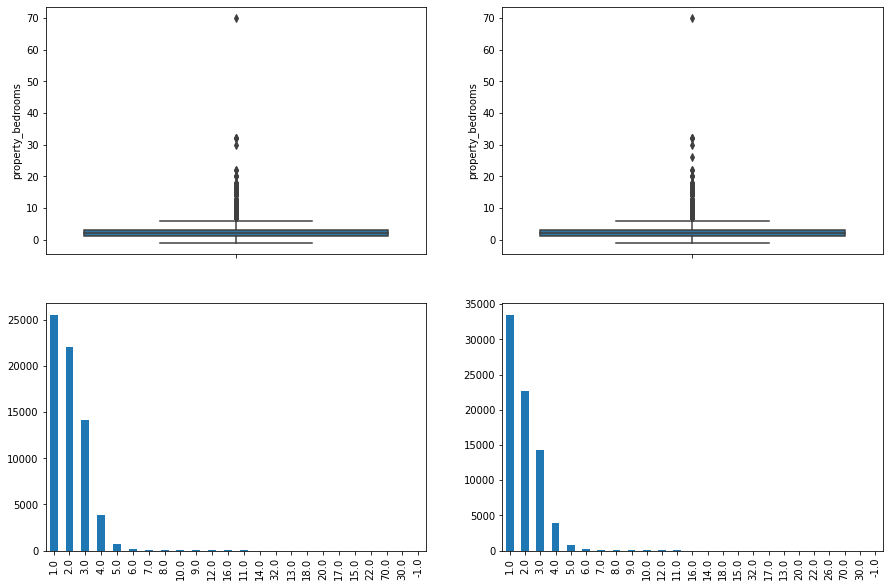

In [196]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(15,10)
sns.boxplot(y="property_bedrooms", data=copia_pre_imputacion, ax=axes[0,0])
sns.boxplot(y="property_bedrooms", data=mice, ax=axes[0,1])
copia_pre_imputacion["property_bedrooms"].value_counts().plot.bar(ax=axes[1,0])
mice["property_bedrooms"].value_counts().plot.bar(ax=axes[1,1])

El grafico nos muestra que la mayoria de los valores faltantes se complentan co una sola habitacion


In [197]:
mice[mice.duplicated(keep=False)]

,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
131374,2021-05-27,2021-08-14,2021-05-27,-34.579478,-58.412496,Capital Federal,Palermo,Venta,Departamento,4.0,3.0,138.0,111.000000,595508.0,USD,BOHO BOTANICO - 4 AMB. PISOS EXCLUSIVOS - PALERMO
337280,2021-04-13,2021-04-13,2021-04-13,NaN,NaN,Capital Federal,Palermo,Venta,Departamento,1.0,1.0,34.0,34.000000,93614.0,USD,Departamento - Palermo Hollywood
275123,2021-09-15,2022-03-09,2021-09-15,-34.623705,-58.440639,Capital Federal,Caballito,Venta,Departamento,3.0,2.0,62.0,62.000000,135000.0,USD,Zona Barrio Ingles. Semipiso al frente con bal...
270584,2021-07-13,2021-07-13,2021-07-13,-34.607641,-58.509193,Capital Federal,Villa Devoto,Venta,Departamento,3.0,2.0,83.0,70.000000,214000.0,USD,Venta Dpto V Devoto 3 Amb c balcon en construc...
241453,2021-04-11,2021-05-15,2021-04-11,-34.554633,-58.495422,Capital Federal,Saavedra,Venta,Departamento,4.0,3.0,105.0,105.000000,208000.0,USD,Departamento - Saavedra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459600,2021-01-05,2021-01-10,2021-01-05,-34.555751,-58.463942,Capital Federal,Belgrano,Venta,Departamento,2.0,1.0,61.0,52.000000,164000.0,USD,Dúplex 2 ambientes con guardacoche balcón parr...
337757,2021-04-13,2021-06-05,2021-04-13,-34.550645,-58.475801,Capital Federal,Saavedra,Venta,Departamento,3.0,2.0,54.0,52.000000,159000.0,USD,HERMOSO Y LUMINOSO DPTO DE 3 AMB CON COCH FIJA...
256803,2021-11-03,2022-01-27,2021-11-03,-34.576814,-58.465850,Capital Federal,Belgrano,Venta,Departamento,5.0,4.0,300.0,236.956988,850000.0,USD,Piso de categoria hecho a nuevo en pleno Belgr...
228981,2021-03-08,2021-06-05,2021-03-08,-34.591820,-58.425686,Capital Federal,Palermo,Venta,Departamento,2.0,1.0,37.0,37.000000,74900.0,USD,Departamento - Palermo


## Analizar la existencia de valores atípicos


### Detectar valores atípicos en los datos en forma univariada


Preparamos el dataset


In [198]:
ds_atipicos = mice.copy()
ds_atipicos_copia = mice.copy()
columnas_a_eliminar = ["start_date", "end_date", "created_on", "latitud", "longitud", "place_l2", "place_l3", "operation", "property_type", "property_currency", "property_title"]
ds_atipicos.drop(columns = columnas_a_eliminar, inplace=True)

Analizamos property_rooms


In [199]:
#z-score Rooms con librería stats
ds_atipicos['z_rooms']=st.zscore(ds_atipicos.property_rooms) #Agregamos columna con valores de z-score

#z-score modificado Rooms con librería stats
mediana_rooms = np.median(ds_atipicos.property_rooms)
MAD=np.median(np.absolute(ds_atipicos.property_rooms - mediana_rooms)) #Mediana de los desvios absolutos
ds_atipicos['zm_rooms']=(ds_atipicos.property_rooms - mediana_rooms)*0.6745/MAD

Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro"


In [200]:
ds_atipicos[ds_atipicos['z_rooms'] > 3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms
9661,12.0,5.0,435.000000,435.000000,850000.0,6.405684,6.0705
201345,9.0,8.0,397.187864,290.000000,400000.0,4.308970,4.0470
22023,8.0,7.0,750.000000,750.000000,1500000.0,3.610066,3.3725
197660,9.0,5.0,408.544993,330.000000,1250000.0,4.308970,4.0470
331525,8.0,6.0,166.000000,144.000000,190000.0,3.610066,3.3725
...,...,...,...,...,...,...,...
196894,8.0,5.0,277.000000,277.000000,640000.0,3.610066,3.3725
117511,9.0,4.0,500.000000,500.000000,2250000.0,4.308970,4.0470
170999,8.0,5.0,316.000000,296.588937,1200000.0,3.610066,3.3725
421588,8.0,7.0,440.000000,235.000000,260000.0,3.610066,3.3725


In [201]:
ds_atipicos[ds_atipicos['z_rooms'] < -3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms


Grafico Boxplot


<AxesSubplot:ylabel='property_rooms'>

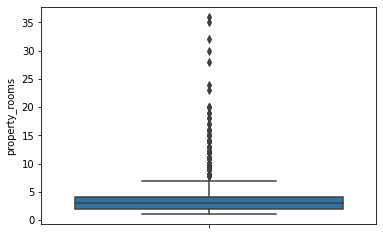

In [202]:
sns.boxplot(y=ds_atipicos.property_rooms)

Anlalizamos property_bedrooms


In [203]:
#z-score
ds_atipicos['z_bedrooms']=st.zscore(ds_atipicos.property_bedrooms)

#z-score modificado
mediana_bedrooms = np.median(ds_atipicos.property_bedrooms)
MAD=np.median(np.absolute(ds_atipicos.property_bedrooms - mediana_bedrooms)) #Mediana de los desvios absolutos
ds_atipicos['zm_bedrooms']=(ds_atipicos.property_bedrooms - mediana_bedrooms)*0.6745/MAD

Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro" y sean posibles outliers


In [204]:
ds_atipicos[ds_atipicos['z_bedrooms'] > 3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms
346603,7.0,6.0,244.000000,244.0,260000.0,2.911161,2.6980,3.607570,2.6980
340949,7.0,6.0,239.348170,160.0,380000.0,2.911161,2.6980,3.607570,2.6980
236625,7.0,6.0,296.634914,215.0,430000.0,2.911161,2.6980,3.607570,2.6980
201345,9.0,8.0,397.187864,290.0,400000.0,4.308970,4.0470,5.373931,4.0470
22023,8.0,7.0,750.000000,750.0,1500000.0,3.610066,3.3725,4.490750,3.3725
...,...,...,...,...,...,...,...,...,...
292695,8.0,7.0,398.000000,277.0,399000.0,3.610066,3.3725,4.490750,3.3725
327194,8.0,6.0,694.092132,600.0,820000.0,3.610066,3.3725,3.607570,2.6980
432687,6.0,6.0,155.000000,120.0,250000.0,2.212257,2.0235,3.607570,2.6980
421588,8.0,7.0,440.000000,235.0,260000.0,3.610066,3.3725,4.490750,3.3725


In [205]:
ds_atipicos[ds_atipicos['z_bedrooms'] < -3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms


Grafico


<AxesSubplot:ylabel='property_bedrooms'>

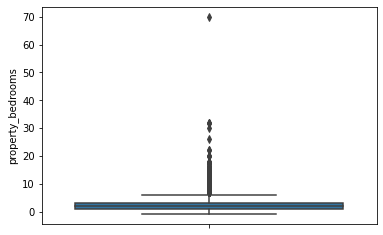

In [206]:
sns.boxplot(y=ds_atipicos.property_bedrooms)

Analizamos property_surface_total


In [207]:
ds_atipicos['z_surface_total']=st.zscore(ds_atipicos.property_surface_total)

Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro" y sean posibles outliers


In [208]:
ds_atipicos[ds_atipicos['z_surface_total'] > 3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_surface_total
370919,5.0,4.0,42110.000000,307.000000,3044250.0,1.513352,1.3490,1.841209,1.3490,31.342154
370921,5.0,4.0,42110.000000,307.000000,2890500.0,1.513352,1.3490,1.841209,1.3490,31.342154
459842,3.0,2.0,8136.000000,6472.000000,203550.0,0.115543,0.0000,0.074849,0.0000,5.985858
189057,4.0,3.0,4200.000000,450.000000,850000.0,0.814448,0.6745,0.958029,0.6745,3.048248
84073,1.0,1.0,36000.000000,30.000000,90000.0,-1.282266,-1.3490,-0.808332,-0.6745,26.781992
106598,2.0,1.0,56740.000000,52540.000000,175000.0,-0.583361,-0.6745,-0.808332,-0.6745,42.261169
459847,4.0,3.0,18096.000000,8568.000000,324558.0,0.814448,0.6745,0.958029,0.6745,13.419446
400155,2.0,1.0,4632.000000,42.000000,129000.0,-0.583361,-0.6745,-0.808332,-0.6745,3.370668
370932,4.0,3.0,42110.000000,307.000000,1691800.0,0.814448,0.6745,0.958029,0.6745,31.342154
370918,4.0,3.0,42110.000000,307.000000,1568760.0,0.814448,0.6745,0.958029,0.6745,31.342154


Grafico


<AxesSubplot:ylabel='property_surface_total'>

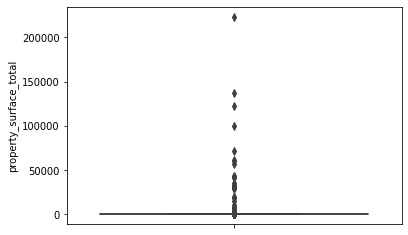

In [209]:
sns.boxplot(y=ds_atipicos.property_surface_total)

Analizamos property_surface_covered


In [210]:
ds_atipicos['z_surface_covered']=st.zscore(ds_atipicos.property_surface_covered)


Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro" y sean posibles outliers


In [211]:
ds_atipicos[ds_atipicos['z_surface_covered'] > 3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_surface_total,z_surface_covered
459842,3.0,2.0,8136.000000,6472.000000,203550.0,0.115543,0.0000,0.074849,0.0000,5.985858,6.114210
106598,2.0,1.0,56740.000000,52540.000000,175000.0,-0.583361,-0.6745,-0.808332,-0.6745,42.261169,50.237945
459847,4.0,3.0,18096.000000,8568.000000,324558.0,0.814448,0.6745,0.958029,0.6745,13.419446,8.121750
352883,1.0,1.0,29064.000000,29064.000000,87400.0,-1.282266,-1.3490,-0.808332,-0.6745,21.605349,27.752732
293109,3.0,2.0,5239.000000,3287.818856,119000.0,0.115543,0.0000,0.074849,0.0000,3.823699,3.064415
233699,2.0,1.0,4224.000000,4224.000000,100000.0,-0.583361,-0.6745,-0.808332,-0.6745,3.066160,3.961086
314541,1.0,1.0,5741.000000,4276.000000,85144.0,-1.282266,-1.3490,-0.808332,-0.6745,4.198364,4.010891
85725,5.0,4.0,3197.000000,3367.000000,12000000.0,1.513352,1.3490,1.841209,1.3490,2.299664,3.140255
372779,4.0,3.0,100068.000000,100051.000000,420000.0,0.814448,0.6745,0.958029,0.6745,74.598769,95.743778
72316,2.0,1.0,61130.000000,53030.000000,225000.0,-0.583361,-0.6745,-0.808332,-0.6745,45.537620,50.707265


Grafico


<AxesSubplot:ylabel='property_surface_covered'>

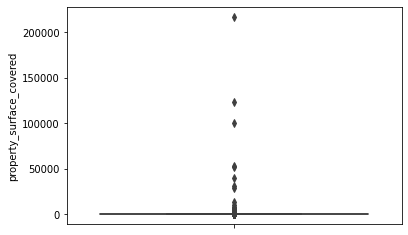

In [212]:
sns.boxplot(y=ds_atipicos.property_surface_covered)

Analizamos property_price


In [213]:
#z-score
ds_atipicos['z_price']=st.zscore(ds_atipicos.property_price)

#z-score modificado
mediana_price = np.median(ds_atipicos.property_price)
MAD=np.median(np.absolute(ds_atipicos.property_price - mediana_price)) 
ds_atipicos['zm_price']=(ds_atipicos.property_price - mediana_price)*0.6745/MAD

Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro" y sean posibles outliers


In [214]:
ds_atipicos[ds_atipicos['z_price'] > 3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_surface_total,z_surface_covered,z_price,zm_price
210381,6.0,5.0,500.0,470.0,2950000.0,2.212257,2.0235,2.724390,2.0235,0.286774,0.365520,8.383816,32.631845
224133,6.0,5.0,550.0,550.0,1580000.0,2.212257,2.0235,2.724390,2.0235,0.324091,0.442144,4.165426,16.699690
229380,4.0,2.0,220.0,220.0,1680000.0,0.814448,0.6745,0.074849,0.0000,0.077798,0.126071,4.473337,17.862621
301217,3.0,2.0,466.0,319.0,3000000.0,0.115543,0.0000,0.074849,0.0000,0.261399,0.220893,8.537772,33.213310
275653,4.0,3.0,346.0,328.0,2000000.0,0.814448,0.6745,0.958029,0.6745,0.171837,0.229513,5.458655,21.584000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
392471,6.0,3.0,276.0,276.0,1350000.0,2.212257,2.0235,0.958029,0.6745,0.119593,0.179708,3.457229,14.024948
342069,4.0,3.0,334.0,334.0,2500000.0,0.814448,0.6745,0.958029,0.6745,0.162881,0.235260,6.998213,27.398655
313226,5.0,3.0,400.0,390.0,2844000.0,1.513352,1.3490,0.958029,0.6745,0.212140,0.288897,8.057429,31.399138
259715,4.0,3.0,224.0,211.0,1250000.0,0.814448,0.6745,0.958029,0.6745,0.080783,0.117451,3.149317,12.862017


Grafico


<AxesSubplot:ylabel='property_price'>

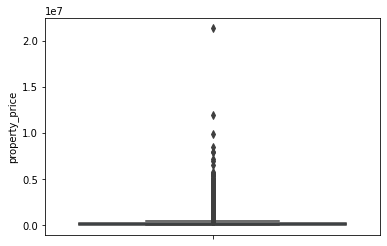

In [215]:
sns.boxplot(y=ds_atipicos.property_price)

### Detectar valores atípicos en los datos en forma multivariada


Utilizamos el metodo de Isolation Forest


In [216]:
from sklearn.ensemble import IsolationForest
#Creo el modelo
iforest = IsolationForest(n_estimators=100, max_samples='auto', 
                          contamination=0.05, max_features=5, 
                          bootstrap=False, n_jobs=-1, random_state=1)

Entreno y genero la predicción


In [217]:

ds_forest = ds_atipicos.drop(columns=["z_rooms","zm_rooms","z_bedrooms","zm_bedrooms","z_surface_total","z_surface_covered","z_price","zm_price"])
pred = iforest.fit_predict(ds_forest)

/home/fanu/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Almaceno scores y etiquetas


In [218]:

ds_forest['scores']=iforest.decision_function(ds_forest)
ds_forest['outlier_label']=pred

#Observaciones anómalas
ds_forest[ds_forest.outlier_label==-1]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,scores,outlier_label
210381,6.0,5.0,500.000000,470.0,2950000.0,-0.201533,-1
401702,7.0,5.0,624.000000,624.0,1111111.0,-0.186345,-1
9661,12.0,5.0,435.000000,435.0,850000.0,-0.178423,-1
363217,6.0,5.0,319.873354,250.0,320000.0,-0.057714,-1
224133,6.0,5.0,550.000000,550.0,1580000.0,-0.187063,-1
...,...,...,...,...,...,...,...
438827,3.0,2.0,352.000000,352.0,300000.0,-0.030188,-1
46275,2.0,1.0,260.000000,240.0,610000.0,-0.052497,-1
361500,7.0,4.0,672.106338,600.0,660000.0,-0.163474,-1
81899,6.0,4.0,390.000000,390.0,2700000.0,-0.145233,-1


Cuento la cantidad de obs anomalas


In [219]:
ds_forest.outlier_label.value_counts()

 1    71629
-1     3770
Name: outlier_label, dtype: int64

Graficos de valores atipicos relacionando las columnas del dataset


#### property_price vs property_rooms


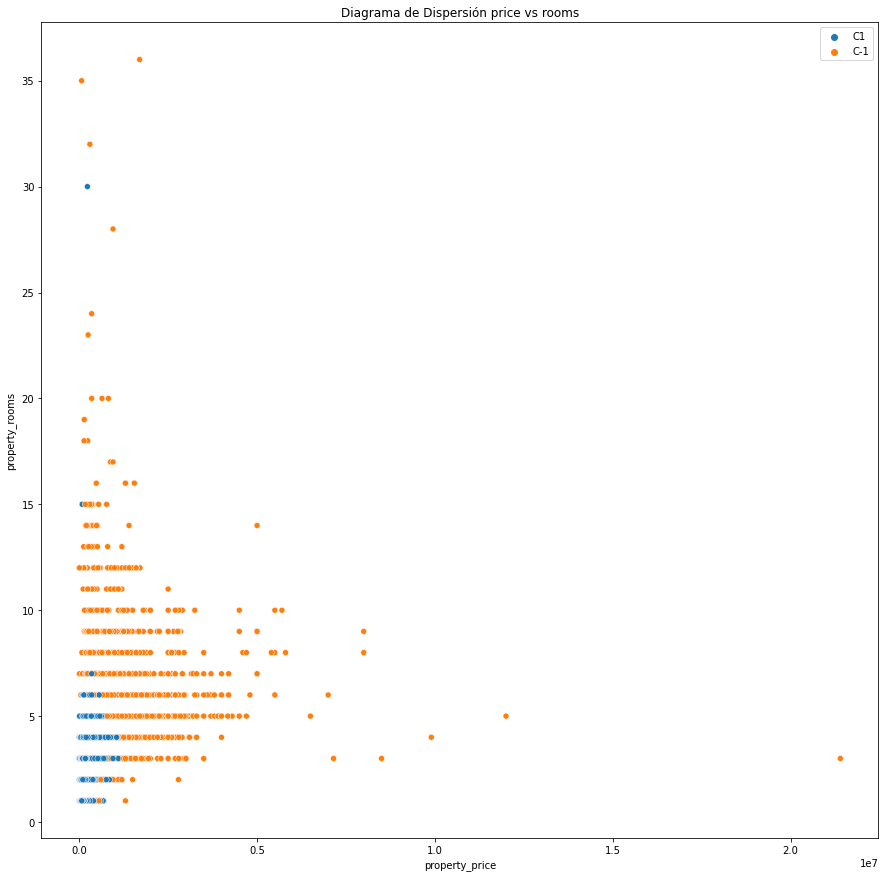

In [220]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(x=ds_forest['property_price'],y=ds_forest['property_rooms'],hue=color)
plt.title('Diagrama de Dispersión price vs rooms')
plt.show()

#### property_bedrooms vs property_rooms


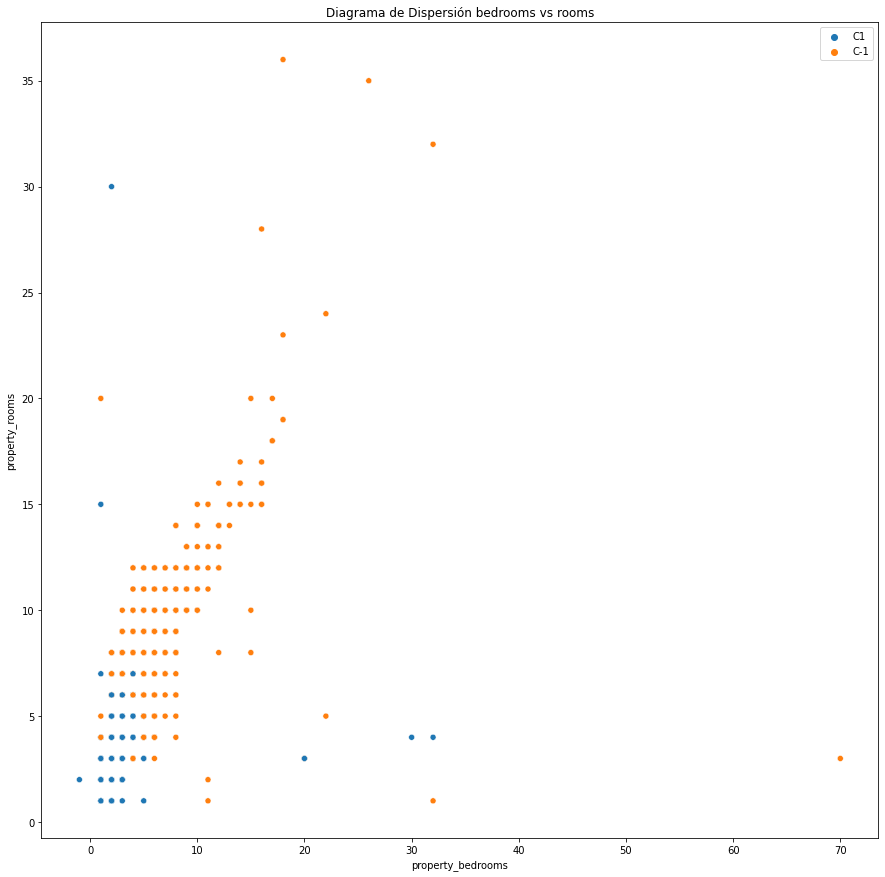

In [221]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(x=ds_forest['property_bedrooms'],y=ds_forest['property_rooms'],hue=color)
plt.title('Diagrama de Dispersión bedrooms vs rooms')
plt.show()

#### property_price vs property_surface_covered


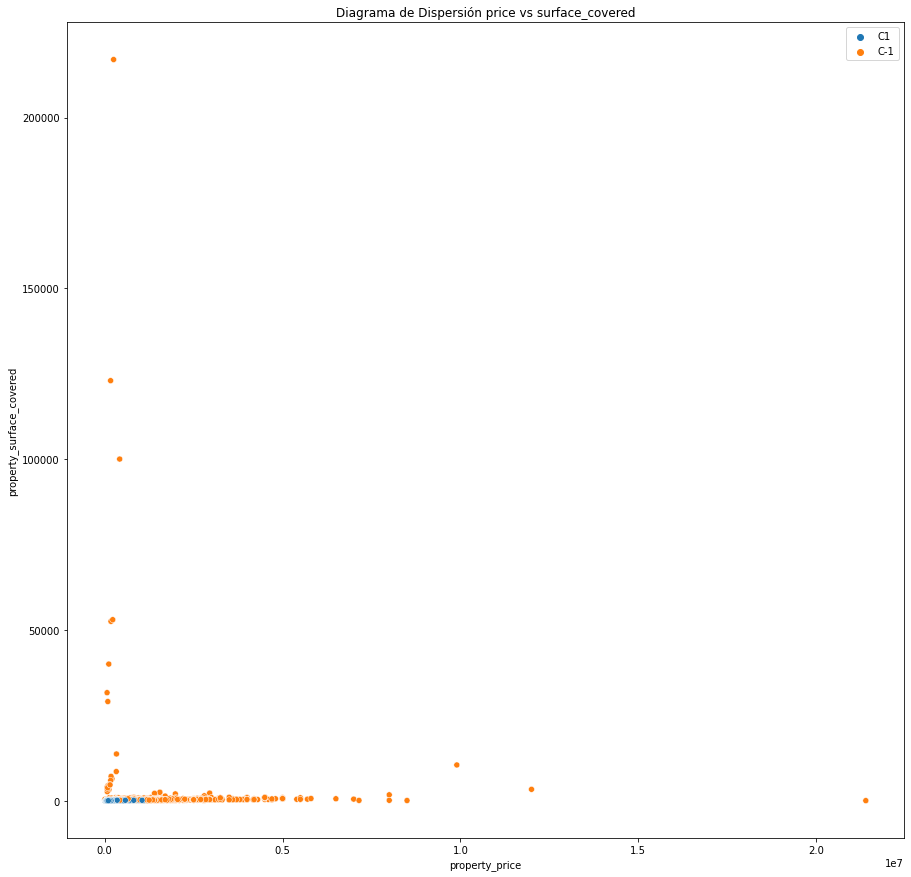

In [222]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(x=ds_forest['property_price'],y=ds_forest['property_surface_covered'],hue=color)
plt.title('Diagrama de Dispersión price vs surface_covered')
plt.show()

#### property_price vs property_surface_total


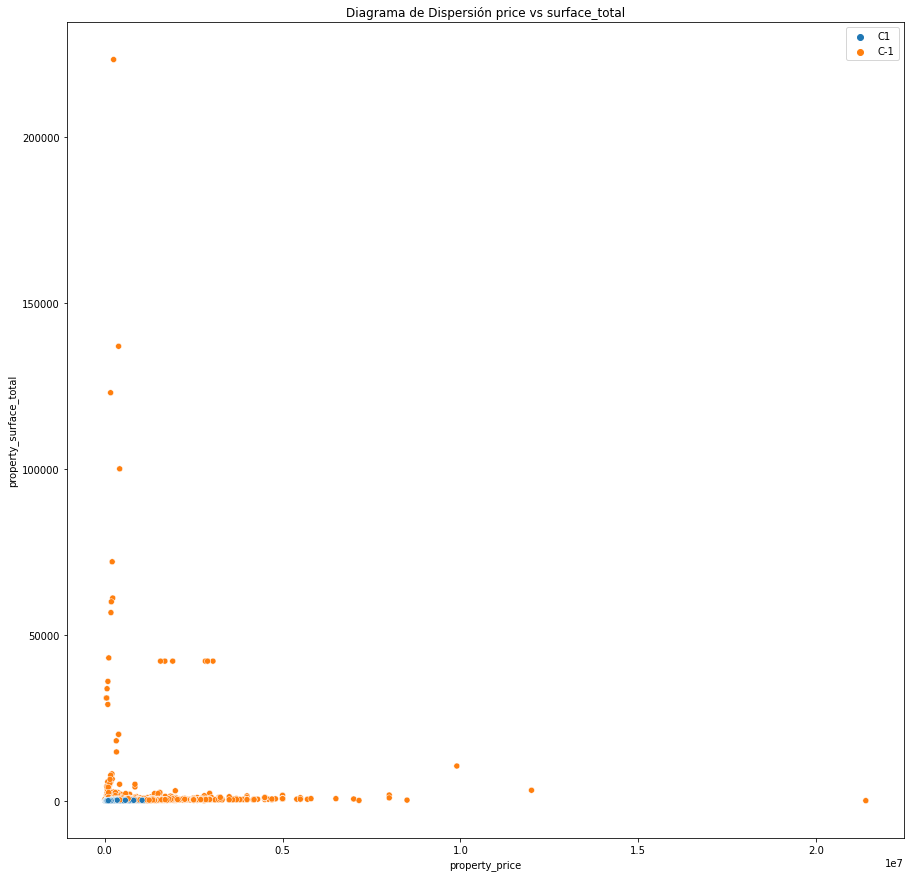

In [223]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(x=ds_forest['property_price'],y=ds_forest['property_surface_total'],hue=color)
plt.title('Diagrama de Dispersión price vs surface_total')
plt.show()

### Caracterisicas de los datos atipicos detectados

Los datos atipicos encontrados de forma univariada tienen la caracteristica que tiene tres o mas desviaciones estándar de la media muestral 
Los datos atipicos detectados de forma multivariada, tienen la caracteristica de ser un valor extremo, pero cuando se lo considera con otra variable, por ejemplo si un departamento tiene un precio extremadamente alto y solo 1 habitacion, o en el caso contrario, de ser un departamento de 10 habitaciones con un precio muy bajo.

### Características y tratamientos de los datos atípicos detectados.


Con los analisis univariados y multivariados que analizamos, concluimos que la mayoria de los datos atipicos los encontramos en valores relacionados con las variables "property_bedrooms", "property_rooms" y "property_price".

Luego de los distintos análisis del dataset pudimos obvservar que al aplicar el método univariado encontramos aquellos outliers con valores extremos en relación a cada columna en particular. En cambio, al implementar el modelo de Isolation Forest para valores atípicos multivariados obtuvimos otras muestras a tener en cuenta como outliers para un mejor tratamiento de los mismos.

Decidimos eliminar solo aquellos valores atipicos, que encontramos en el analisis multivariado y univariado de "property_bedrooms", "property_rooms" y "property_price", esta decision la tomamos debido a que la coincidencia de el analisis univariado y multivariado nos da una certeza mas alta de que verdaderamente estamos eliminando valores erroneos.

En cuanto al analisis de "property_surface_covered" y "property_surface_total" decidimos eliminar todos los valores atipicos obtenidos con el modelo z-score


Eliminacion de valores atipicos detectados en forma univariada de surface_total & surface_covered


In [224]:
indice_surface_total = ds_atipicos[ds_atipicos['z_surface_total'] > 3 ].index.to_list()
indice_surface_covered = ds_atipicos[ds_atipicos['z_surface_covered'] > 3 ].index.to_list()
indice_a_eliminar_directo = indice_surface_total + indice_surface_covered
ds_atipicos = ds_atipicos.drop(index=indice_a_eliminar_directo)

Eliminacion de valores atipicos coincidentes en ambos metodos


In [225]:
from collections import OrderedDict
from iteration_utilities import duplicates # hay que instalar iteration_utilities "pip install iteration_utilities"
from iteration_utilities import unique_everseen
indice_price = ds_atipicos[ds_atipicos['z_price'] > 3 ].index.to_list()
indice_bedrooms = ds_atipicos[ds_atipicos['z_bedrooms'] > 3 ].index.to_list()
indice_rooms = ds_atipicos[ds_atipicos['z_rooms'] > 3 ].index.to_list()
indice_multi_variable = ds_forest[ds_forest.outlier_label==-1].index.to_list()
indice_a_eliminar = indice_price + indice_bedrooms + indice_rooms
indice_a_eliminar = list(OrderedDict.fromkeys(indice_a_eliminar))
indice_a_eliminar = indice_a_eliminar + indice_multi_variable
a = list(unique_everseen(duplicates(indice_a_eliminar)))
ds_atipicos = ds_atipicos.drop(index=a)
ds_atipicos_copia = ds_atipicos_copia.drop(index = a)

### Analizar la relación entre el precio de venta y los metros de superficie


volvemos a hacer el analisis despues de la depuracion


In [226]:
iforest = IsolationForest(n_estimators=100, max_samples='auto', 
                          contamination=0.05, max_features=5, 
                          bootstrap=False, n_jobs=-1, random_state=1)

Entreno y genero la predicción


In [227]:

ds_forest = ds_atipicos.drop(columns=["z_rooms","zm_rooms","z_bedrooms","zm_bedrooms","z_surface_total","z_surface_covered","z_price","zm_price"])
pred = iforest.fit_predict(ds_forest)

/home/fanu/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [228]:
ds_forest['scores']=iforest.decision_function(ds_forest)
ds_forest['outlier_label']=pred

#Observaciones anómalas
ds_forest[ds_forest.outlier_label==-1]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,scores,outlier_label
413132,5.0,3.0,290.000000,230.0,815000.0,-0.075728,-1
354298,5.0,4.0,254.000000,245.0,750000.0,-0.059887,-1
401702,7.0,5.0,624.000000,624.0,1111111.0,-0.210288,-1
349977,5.0,4.0,270.000000,265.0,669000.0,-0.062640,-1
106900,4.0,2.0,210.000000,201.0,790000.0,-0.045979,-1
...,...,...,...,...,...,...,...
46275,2.0,1.0,260.000000,240.0,610000.0,-0.076214,-1
438440,6.0,4.0,300.000000,224.0,350000.0,-0.054517,-1
361500,7.0,4.0,672.106338,600.0,660000.0,-0.186984,-1
190769,7.0,4.0,292.000000,187.0,430000.0,-0.083309,-1


cantidad de obs. anómalas


In [229]:
ds_forest.outlier_label.value_counts()

 1    69867
-1     3678
Name: outlier_label, dtype: int64

Grafico dispersograma


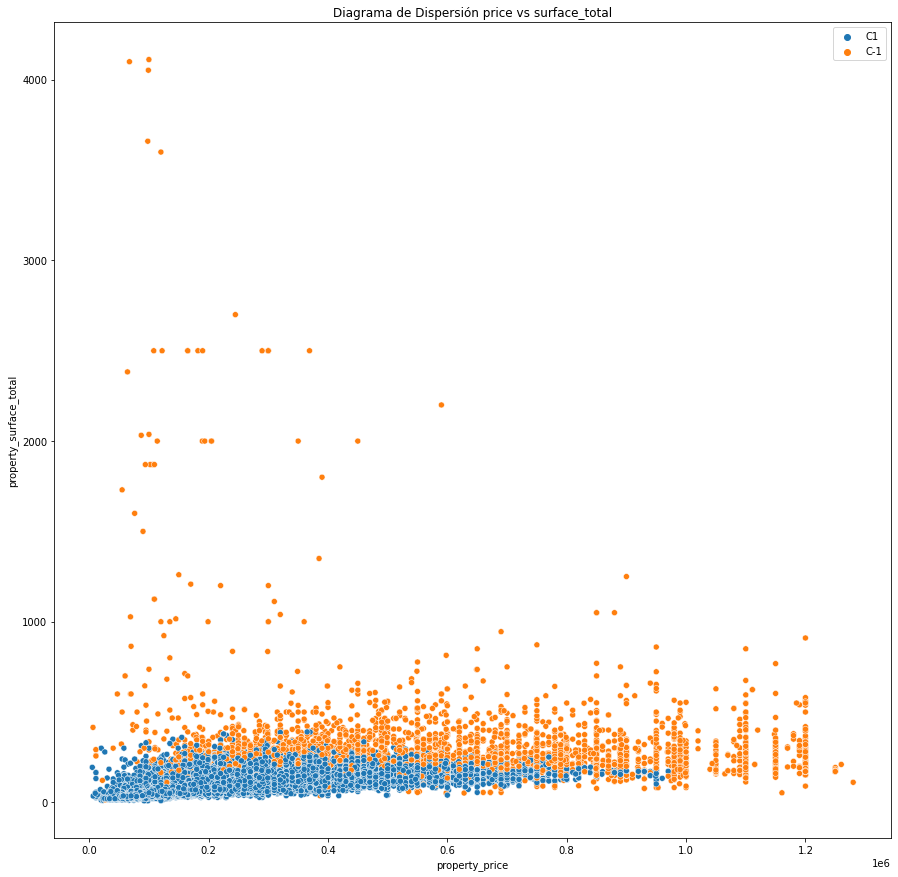

In [230]:
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(x=ds_forest['property_price'],y=ds_forest['property_surface_total'],hue=color)
plt.title('Diagrama de Dispersión price vs surface_total')
plt.show()

Los outliers en casos multivariados como los que analizamos previamente, pueden provocar un efecto de enmascaramietno que se produce cuando un grupo de outliers esconden a otros. Es decir, los outliers enmascarados se haran visibles cuando se eliminen los outliers que los esconden.
En nuestro caso, observamos como al eliminar la primer tanda de valores atipicos y realizar el analisis nuevamente, encontramos nuevos outliers.


In [235]:
#indice_multi_variable es el index de los outliers que detectamos mas arriba

indice_multi_variable_2 = ds_forest[ds_forest.outlier_label==-1].index.to_list()
nuevos_outliers = []
for i in indice_multi_variable_2:
    if(i not in indice_multi_variable): nuevos_outliers.append(i)
print(len(nuevos_outliers))

1762


Vemos que eliminando los outliers que detectamos mas arriba y volviendo a utilizar Isolation Forest para la deteccion de outliers, detectamos 1762 nuevos outliers.

Analizando el grafico podemos observar que los valores atipicos suelen aparecer donde "property_price" es relativamente bajo y "property_surface_total" alto y viceversa, donde el "property_price" es alto y el "property_surface_total" muy bajo

## Reduccion De La Dimensionalidad


In [70]:
#Creamos el dataset que será utilizado para la reducción y uliminamos todas las filas con columnas vacías
ds_prop_reducido = ds_atipicos_copia.copy()
ds_prop_reducido = ds_prop_reducido.dropna()

Comenzamos eliminando las variables que ya sabemos no tienen influencia en el precio


In [71]:
variables_eliminadas = ["start_date", "end_date", "created_on", "property_title"]
ds_prop_reducido = ds_prop_reducido.drop(variables_eliminadas, axis='columns', inplace=False)

#Estado del dataset reducido
ds_prop_reducido.head()

,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency
161952,-34.540279,-58.464803,Capital Federal,Nuñez,Venta,Departamento,3.0,2.0,61.0,56.0,130000.0,USD
308773,-34.606780,-58.391341,Capital Federal,San Nicolás,Venta,Departamento,2.0,1.0,73.0,62.0,120000.0,USD
367023,-34.569511,-58.456376,Capital Federal,Colegiales,Venta,Departamento,4.0,3.0,157.0,135.0,400000.0,USD
180464,-34.587250,-58.446779,Capital Federal,Chacarita,Venta,Departamento,2.0,1.0,36.0,36.0,93000.0,USD
362258,-34.606312,-58.493226,Capital Federal,Floresta,Venta,PH,3.0,2.0,45.0,45.0,75000.0,USD


Analizamos Correlaciones


In [72]:
ds_prop_reducido.corr()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
latitud,1.000000,-0.138511,-0.047615,-0.045489,-0.001038,-0.002924,0.187528
longitud,-0.138511,1.000000,-0.019855,-0.020695,0.000279,0.001582,0.087668
property_rooms,-0.047615,-0.019855,1.000000,0.905547,0.091408,0.101391,0.552753
property_bedrooms,-0.045489,-0.020695,0.905547,1.000000,0.094219,0.104747,0.544022
property_surface_total,-0.001038,0.000279,0.091408,0.094219,1.000000,0.711898,0.077604
property_surface_covered,-0.002924,0.001582,0.101391,0.104747,0.711898,1.000000,0.047348
property_price,0.187528,0.087668,0.552753,0.544022,0.077604,0.047348,1.000000


Se puede ver la fuerte correlación entre 'property_rooms' y property_bedrooms'. Al analizarla, vemos que 'property_rooms' son la cantidad de ambientes del inmueble (habitaciones más el comedor), mientras 'property_bedrooms' hace referencia a la cantidad de dormitorios. Un dormitorio cuenta como habitacion, por lo tanto si aumenta 'property_bedrooms', aumentará 'property_rooms'.
Por lo tanto es claro que hay una posible reducción. Si vamos a la pagina 'https://www.properati.com.ar/data/', el esquema de avisos nos informa que 'property_bedrooms' no es útil para los avisos en Argentina. Asi que elegimos eliminar del dataset 'property_bedrooms'.

Lo mismo sucede con las variables 'property_surface_total' y 'property_surace_covered'. Están fuertemente correlacionadas ya que si aumente property_surface_covered', aumenta 'property_surface_total'. Por lo tanto eliminamos 'property_surface_covered'.


In [73]:
variables_eliminadas = ["property_bedrooms", "property_surface_covered"]
ds_prop_reducido = ds_prop_reducido.drop(variables_eliminadas, axis='columns', inplace=False)

#Estado del dataset reducido
ds_prop_reducido.head()

,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_surface_total,property_price,property_currency
161952,-34.540279,-58.464803,Capital Federal,Nuñez,Venta,Departamento,3.0,61.0,130000.0,USD
308773,-34.606780,-58.391341,Capital Federal,San Nicolás,Venta,Departamento,2.0,73.0,120000.0,USD
367023,-34.569511,-58.456376,Capital Federal,Colegiales,Venta,Departamento,4.0,157.0,400000.0,USD
180464,-34.587250,-58.446779,Capital Federal,Chacarita,Venta,Departamento,2.0,36.0,93000.0,USD
362258,-34.606312,-58.493226,Capital Federal,Floresta,Venta,PH,3.0,45.0,75000.0,USD


Analizamos la varianza de atributos


Debido a la filtracion del datset originales, vemos que las variables 'place_l2', 'property_currency' y 'operation' tienen todas el mismo valor. Como son todas iguales, no van a tener peso a la hora de modificar el precio, por lo tanto las eliminamos


In [74]:
variables_eliminadas = ["place_l2", "property_currency", "operation"]
ds_prop_reducido = ds_prop_reducido.drop(variables_eliminadas, axis='columns', inplace=False)

#Estado del dataset reducido
ds_prop_reducido.head()

,latitud,longitud,place_l3,property_type,property_rooms,property_surface_total,property_price
161952,-34.540279,-58.464803,Nuñez,Departamento,3.0,61.0,130000.0
308773,-34.606780,-58.391341,San Nicolás,Departamento,2.0,73.0,120000.0
367023,-34.569511,-58.456376,Colegiales,Departamento,4.0,157.0,400000.0
180464,-34.587250,-58.446779,Chacarita,Departamento,2.0,36.0,93000.0
362258,-34.606312,-58.493226,Floresta,PH,3.0,45.0,75000.0


Analizamos la importancia de los atributos


In [75]:
#One Hot Encoding para variables categoricas
variables_reemplazadas = ["property_type", "place_l3"]
ds_prop_arbol = pd.get_dummies(ds_prop_reducido, columns=variables_reemplazadas, drop_first=True)

#Creo dataset con los features que se van a usar para clasificar
variables_eliminadas = ['property_price']
ds_prop_filtrado_x = ds_prop_arbol.drop(variables_eliminadas, axis='columns', inplace=False)

scaler = MinMaxScaler()
ds_prop_filtrado_x["property_surface_total"] = scaler.fit_transform(ds_prop_filtrado_x["property_surface_total"].to_frame())
ds_prop_filtrado_x["longitud"] = scaler.fit_transform(ds_prop_filtrado_x["longitud"].to_frame())
ds_prop_filtrado_x["latitud"] = scaler.fit_transform(ds_prop_filtrado_x["latitud"].to_frame())

#Creo dataset con la variable target

ds_prop_filtrado_y = ds_prop_arbol['property_price'].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_prop_filtrado_x, 
                                                    ds_prop_filtrado_y, 
                                                    test_size=0.2, #proporción 90/10 
                                                    random_state=9) #semilla

tree_model = tree.DecisionTreeClassifier(criterion="entropy",max_depth=20, min_samples_leaf=2)

#Entrenamos el modelo
model = tree_model.fit(X=x_train, y=y_train)
y_pred = model.predict(x_test)

#Calculamos las métricas en el conjunto de evaluación
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: " + str(rmse))

RMSE: 79432.14885806353


In [76]:
#Importancia de los atributos de mayor a menor
sorted(list(zip(ds_prop_filtrado_x.columns.to_list(), model.feature_importances_)), key=lambda x: -x[1])

[('latitud', 0.3125495139444552),
 ('property_surface_total', 0.31017581501269714),
 ('longitud', 0.2875163289620013),
 ('property_rooms', 0.03567046364453855),
 ('property_type_Departamento', 0.007460754133700837),
 ('place_l3_Caballito', 0.006291175028871747),
 ('property_type_PH', 0.0058785997283340415),
 ('place_l3_Puerto Madero', 0.005637812660867491),
 ('place_l3_Palermo', 0.002680451862228328),
 ('place_l3_Villa Urquiza', 0.0023567925782717438),
 ('place_l3_Recoleta', 0.0020431258029910216),
 ('place_l3_Balvanera', 0.001623975864232946),
 ('place_l3_Barrio Norte', 0.0015355829640297173),
 ('place_l3_Almagro', 0.0014327459199209955),
 ('place_l3_Belgrano', 0.00138557850846621),
 ('place_l3_Flores', 0.0012775400211525918),
 ('place_l3_Villa Crespo', 0.0010163700361087715),
 ('place_l3_Monserrat', 0.0008274901569009769),
 ('place_l3_San Telmo', 0.0008252788641044164),
 ('place_l3_Villa del Parque', 0.0007548551811672822),
 ('place_l3_San Nicolás', 0.0007518330887486464),
 ('place_l

Vemos como las variable 'place_l3' tienen muy poca importancia en el arbol de decision. Por lo tanto, las eliminamos


In [77]:
variables_eliminadas = ["place_l3"]
ds_prop_reducido = ds_prop_reducido.drop(variables_eliminadas, axis='columns', inplace=False)

#Estado del dataset reducido
ds_prop_reducido.head()

,latitud,longitud,property_type,property_rooms,property_surface_total,property_price
161952,-34.540279,-58.464803,Departamento,3.0,61.0,130000.0
308773,-34.606780,-58.391341,Departamento,2.0,73.0,120000.0
367023,-34.569511,-58.456376,Departamento,4.0,157.0,400000.0
180464,-34.587250,-58.446779,Departamento,2.0,36.0,93000.0
362258,-34.606312,-58.493226,PH,3.0,45.0,75000.0


Hacemos PCA para analizar posibles reducciones


In [78]:
ds_prop_reducido_pca = ds_prop_reducido.copy()

columnas_elegidas = ["latitud", "longitud", "property_rooms", "property_surface_total"]

x = ds_prop_reducido_pca.loc[:, columnas_elegidas].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=4) 
x_transformada = pca.fit_transform(x)

pca_df_aux = pd.DataFrame(data = x_transformada
             , columns = ['cp_1', 'cp_2','cp_3','cp_4'])


print("Variabilidad explicada por cada componente:"  + str(pca.explained_variance_ratio_))

Variabilidad explicada por cada componente:[0.28594817 0.27298118 0.23099145 0.2100792 ]


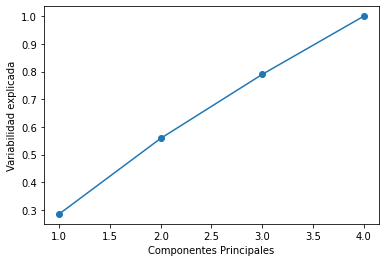

In [79]:
variabilidad_explicada = pca.explained_variance_ratio_
list_x = list(range(1, len(variabilidad_explicada)+1))

# Grafico varianza explicada y cantidad de componentes principales
plt.figure(figsize=(6, 4))
plt.plot(list_x, variabilidad_explicada.cumsum(), '-o')
plt.xlabel(r'Componentes Principales')
plt.ylabel('Variabilidad explicada')
plt.show()

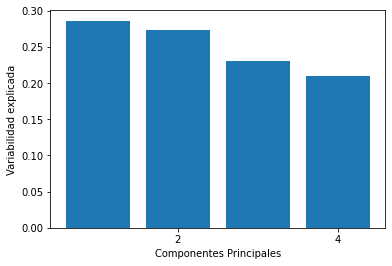

In [80]:
list_x = list(range(1, len(variabilidad_explicada)+1))

# Grafico varianza explicada y cantidad de componentes principales

plt.locator_params('x', nbins = 4)
plt.bar(list_x, variabilidad_explicada)
plt.xlabel(r'Componentes Principales')
plt.ylabel('Variabilidad explicada')
plt.show()

Vemos como los cuatro componentes tienen una canidad significativa de variablididad explicada. Por lo tanto aplicarle PCA al dataset resultaría en una perdida de información elevada. De esta forma concluimos que no es beneficioso realizar PCA


#### Persistencia archivos


In [81]:
#Guardamos el dataset reducido
train, test = train_test_split(ds_prop_reducido,
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=0)
print('# Datos Entrenamiento: {}'.format(len(train)))
print('# Datos Prueba: {}'.format(len(test)))

train.to_csv("properati_argentina_reducido_train.csv")
test.to_csv("properati_argentina_reducido_test.csv")

# Datos Entrenamiento: 55716
# Datos Prueba: 13929


In [82]:
ds_prop_reducido

,latitud,longitud,property_type,property_rooms,property_surface_total,property_price
161952,-34.540279,-58.464803,Departamento,3.0,61.0,130000.0
308773,-34.606780,-58.391341,Departamento,2.0,73.0,120000.0
367023,-34.569511,-58.456376,Departamento,4.0,157.0,400000.0
180464,-34.587250,-58.446779,Departamento,2.0,36.0,93000.0
362258,-34.606312,-58.493226,PH,3.0,45.0,75000.0
...,...,...,...,...,...,...
108573,-34.654809,-58.404746,Departamento,3.0,59.0,55000.0
238236,-34.581673,-58.443382,Departamento,1.0,40.0,110000.0
221078,-34.597355,-58.395413,Departamento,3.0,101.0,207000.0
226504,-34.607323,-58.512419,Departamento,3.0,65.0,120000.0


# Agrupamiento


## Clustering


In [83]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans

Sacamos columnas que no se utilizan


In [84]:
ds_kmeans = ds_atipicos_copia.copy()
columnas = ["start_date", "end_date", "created_on", "place_l2", "place_l3", "operation", "property_currency", "property_title", "latitud", "longitud"]
ds_kmeans.drop(columns = columnas, inplace = True)

Aplicamos dummies para property_type


In [85]:
ds_kmeans = pd.get_dummies(ds_kmeans, columns=['property_type'])
ds_kmeans

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_type_Casa,property_type_Departamento,property_type_PH
161952,3.0,2.0,61.0,56.0,130000.0,0,1,0
308773,2.0,1.0,73.0,62.0,120000.0,0,1,0
367023,4.0,3.0,157.0,135.0,400000.0,0,1,0
180464,2.0,1.0,36.0,36.0,93000.0,0,1,0
362258,3.0,2.0,45.0,45.0,75000.0,0,0,1
...,...,...,...,...,...,...,...,...
108573,3.0,2.0,59.0,59.0,55000.0,0,1,0
238236,1.0,1.0,40.0,35.0,110000.0,0,1,0
221078,3.0,2.0,101.0,91.0,207000.0,0,1,0
226504,3.0,2.0,65.0,57.0,120000.0,0,1,0


Aplicamos MinMaxScaler para variables numericas


In [86]:
scaler = MinMaxScaler()
ds_kmeans["property_surface_total"] = scaler.fit_transform(ds_kmeans["property_surface_total"].to_frame())
ds_kmeans["property_surface_covered"] = scaler.fit_transform(ds_kmeans["property_surface_covered"].to_frame())
ds_kmeans["property_price"] = scaler.fit_transform(ds_kmeans["property_price"].to_frame())
ds_kmeans["property_bedrooms"] = scaler.fit_transform(ds_kmeans["property_bedrooms"].to_frame())
ds_kmeans["property_rooms"] = scaler.fit_transform(ds_kmeans["property_rooms"].to_frame())
ds_kmeans

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_type_Casa,property_type_Departamento,property_type_PH
161952,0.051282,0.032258,0.000307,0.000258,0.010421,0,1,0
308773,0.025641,0.000000,0.000380,0.000286,0.009587,0,1,0
367023,0.076923,0.064516,0.000886,0.000622,0.032930,0,1,0
180464,0.025641,0.000000,0.000157,0.000166,0.007336,0,1,0
362258,0.051282,0.032258,0.000211,0.000207,0.005836,0,0,1
...,...,...,...,...,...,...,...,...
108573,0.051282,0.032258,0.000295,0.000272,0.004168,0,1,0
238236,0.000000,0.000000,0.000181,0.000161,0.008754,0,1,0
221078,0.051282,0.032258,0.000548,0.000419,0.016840,0,1,0
226504,0.051282,0.032258,0.000331,0.000263,0.009587,0,1,0


### Estimamos la cantidad apropiada de grupos que se deben formar.


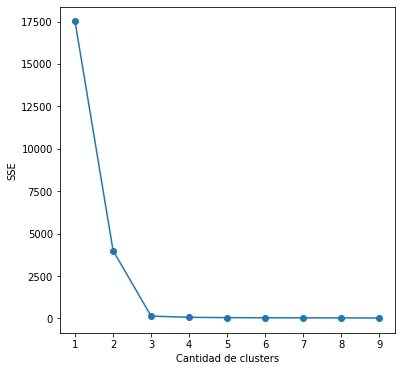

In [87]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(ds_kmeans)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

En este caso son 3


Aplicamos k-means con la cantidad de clusters indicados por la regla del codo


In [88]:
kmeans = KMeans(3, random_state=123)
kmeans.fit(ds_kmeans)

KMeans(n_clusters=3, random_state=123)

In [89]:
clusters = kmeans.predict(ds_kmeans)
ds_kmeans["cluster"] = clusters

### Silhouette


/home/fanu/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


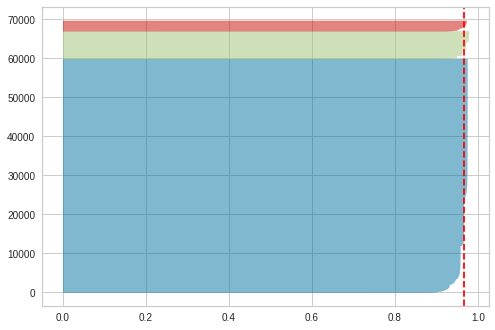

In [90]:
from yellowbrick.cluster import SilhouetteVisualizer

# Visualizamos el gráfico de silueta
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')    # Instancio el visualizador
visualizer.fit(ds_kmeans.drop(columns=["cluster"]))
plt.show()

Como se observa en el grafico, tenemos 3 grupos sin mediciones que esten mas cerca de otro cluster que del que pertenecen.


### Analisis por grupo


In [91]:
ds_kmeans.shape

(69645, 9)

Como se puede observar, los grupos fueron creados en funcion de la caracteristica de property_type.
El cluster 0 es propiedad del tipo Departamento, el cluster 1 propiedad del tipo PH y el cluster 2 porpiedad de tipo casa


In [92]:
ds_kmeans["property_type"] = ds_atipicos_copia["property_type"]
pd.crosstab(ds_kmeans['cluster'],ds_kmeans['property_type'])

property_type,Casa,Departamento,PH
cluster,,,
0,0,59868,0
1,0,0,7135
2,2642,0,0


### Mapa


Delimitacionn de capital federal


In [93]:
ds_mapa_point = geopandas.GeoDataFrame(ds_atipicos_copia, geometry=geopandas.points_from_xy(ds_atipicos_copia.longitud, ds_atipicos_copia.latitud))
ds_mapa_capital = geopandas.read_file("barrios_2/barrios-polygon.shp")

In [94]:
ds_mapa_point["cluster"] = ds_kmeans["cluster"]

fig, ax = plt.subplots()
x=ds_clasificacion["latitud"]
y=ds_clasificacion["longitud"]
ds_clasificacion.loc[ds_clasificacion['precioxm2_q'] == "bajo",'color'] = 1
ds_clasificacion.loc[ds_clasificacion['precioxm2_q'] == "medio",'color'] = 2
ds_clasificacion.loc[ds_clasificacion['precioxm2_q'] == "alto",'color'] = 3

scatter = ax.scatter(x, y, c=ds_clasificacion['color'])
legend1 = ax.legend(\*scatter.legend_elements(),
title="Classes")
ax.add_artist(legend1)
plt.show()


Text(0.5, 1.0, 'Mapa de propiedades en CABA')

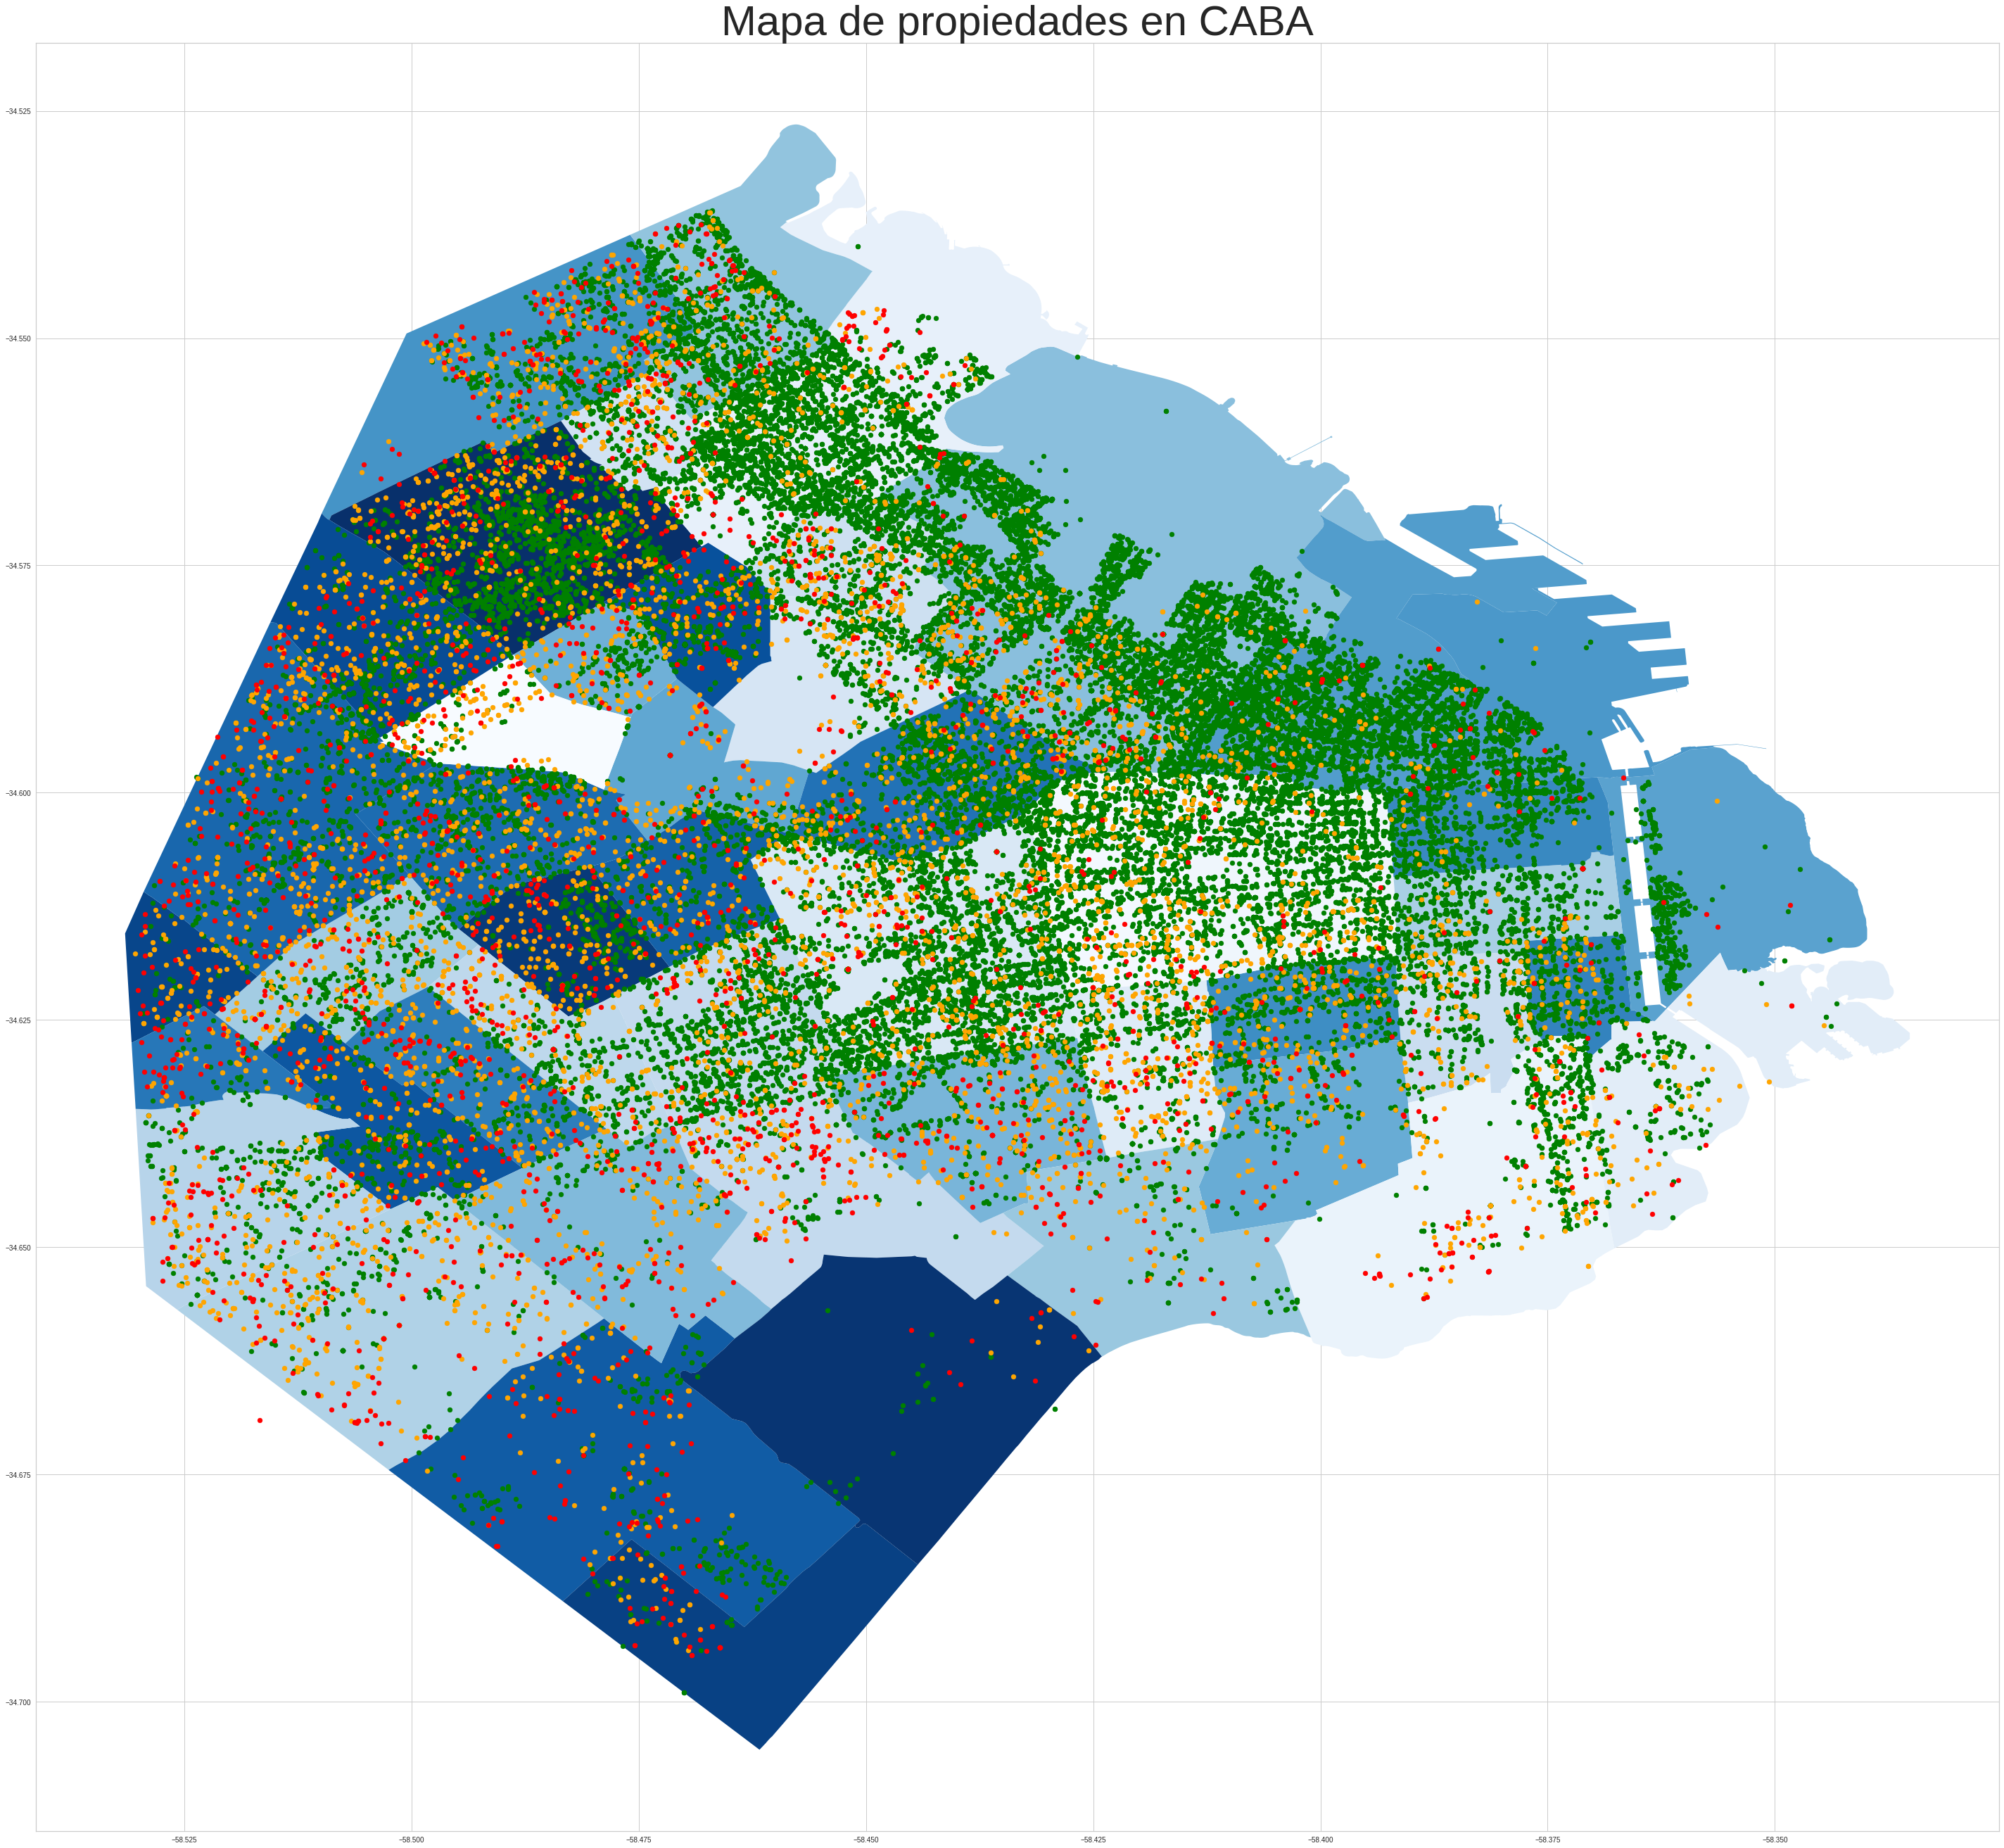

In [95]:
fig,ax = plt.subplots(figsize = (50,50))
ds_mapa_capital.plot(ax = ax, column = "BARRIO", cmap = "Blues")
ds_mapa_point[ds_mapa_point["cluster"] == 0].plot(ax = ax, color = "green") # departamentos
ds_mapa_point[ds_mapa_point["cluster"] == 1].plot(ax = ax, color = "orange") #ph
ds_mapa_point[ds_mapa_point["cluster"] == 2].plot(ax = ax, color = "red") # casa
ax.set_title("Mapa de propiedades en CABA", fontdict = {"fontsize" : "60"})